In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rospy
import pickle

Text(0.5, 0, 'Time (sec)')

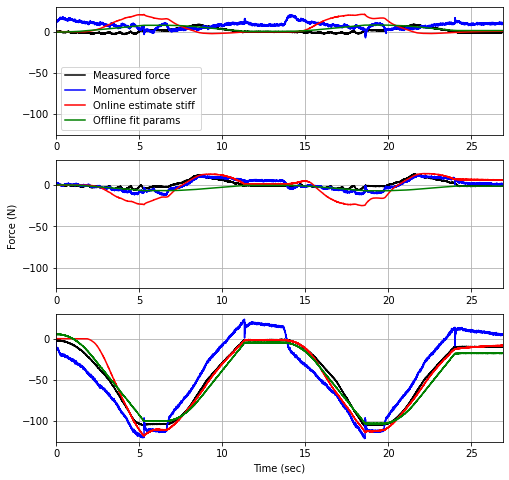

In [22]:
# Plotting the estimated force, observer force, measured force

traj = 'data/ur_vertical_3_stiff.pkl' # estimating stiffness online
with open(traj, 'rb') as f:
    states, _, _, _, stiff, _, f_ee_obs_stiff, f_ee, true_pos, true_vel = pickle.load(f)

#traj = 'data/ur_vertical_3_offline.pkl' # all fit parameters
traj = 'data/ur_vertical_3.pkl' # all fit parameters
with open(traj, 'rb') as f:
    _, _, _, _, _, f_ee_mo, f_ee_obs_off, f_ee, _, _ = pickle.load(f)

    
f_ee[0,:] *= -1
f_ee[1,:] *= -1    

fig, axs = plt.subplots(3,1,figsize=(8,8))
t = np.array([range(f_ee.shape[1])]).squeeze()/500.
time = t#range(0,5000)

for ind, ax in enumerate(axs):
    axs[ind].plot(t, f_ee[ind], 'k', label="Measured force")
    axs[ind].plot(t, f_ee_mo[ind], 'b', label= "Momentum observer")
    axs[ind].plot(t, f_ee_obs_stiff[ind], 'r', label= "Online estimate stiff")
    axs[ind].plot(t, f_ee_obs_off[ind], 'g', label= "Offline fit params")
    axs[ind].grid(True)
    axs[ind].set_xlim([t[0],t[-1]])
    axs[ind].set_ylim([-125,30])
axs[0].legend() 
#plt.xlabel('Force (N)')
fig.text(0.04, 0.5, 'Force (N)', va='center', rotation='vertical')
plt.xlabel('Time (sec)')


In [ ]:
traj = 'data/ur_vertical_3.pkl'

fig = plt.figure(figsize=(12,7))
plt.plot(time, stiff[0,time], 'r')
plt.plot(time, stiff[1,time], 'g')
plt.plot(time, stiff[2,time], 'b')
fig = plt.figure(figsize=(12,7))
jt = 1

time = range(500,3000)
plt.plot(time, true_pos[jt,time].T, label="true position")
plt.plot(time, states[jt,time].T, label="estimated position")
plt.legend()

fig = plt.figure(figsize=(12,7))
plt.plot(time, true_vel[jt,time].T, label="true velocities")
plt.plot(time, states[jt+6,time].T, label="estimated velocities")

plt.legend()
plt.show()

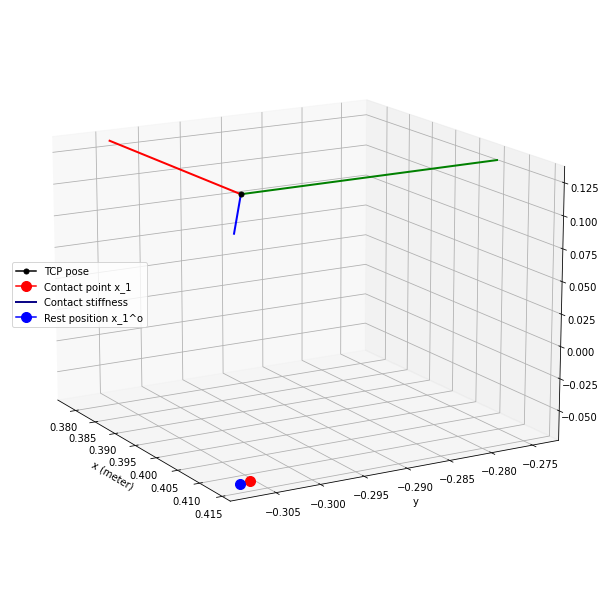

In [3]:
# Plotting the positoin and orientation of the robot and the estimated contact point
#%matplotlib
#traj = 'data/racer_rotate_long_4.pkl'
traj = 'data/ur_vertical_1.pkl'

rest_pos = rospy.get_param('contact_1_rest', [0.0, 0.0, 0.0]) 
#stiff = rospy.get_param('contact_1_stiff', [0.0, 0.0, 0.0]) 
scale = 0.03
scales = 5e-3#3e-6

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection="3d")
with open(traj, 'rb') as f:
    _, _, x_is, x_ees, stiffs = pickle.load(f)

num_pts = x_is.shape[1]
pos_last = x_ees[0][0]
min_dist = 0.008
cmap = plt.get_cmap('plasma')
for i, (xi, xee, stiff) in enumerate(zip(x_is.T, x_ees, stiffs.T)):
    p = np.array(xee[0]).flatten()
    o = np.array(xee[1])
    if np.linalg.norm(p[:3] - pos_last[:3]) < min_dist:
        continue
    else:
        pos_last = p
    x = np.array(o[0,:])
    y = np.array(o[1,:])
    z = np.array(o[2,:])
    xs = o@stiff
    
    ax.plot([p[0], p[0]+scale*x[0]],
            [p[1], p[1]+scale*x[1]],
            [p[2], p[2]+scale*x[2]],
            'r', linewidth=2)
    ax.plot([p[0], p[0]+scale*y[0]],
            [p[1], p[1]+scale*y[1]],
            [p[2], p[2]+scale*y[2]],
            'g', linewidth=2)
    ax.plot([p[0], p[0]+scale*z[0]],
            [p[1], p[1]+scale*z[1]],
            [p[2], p[2]+scale*z[2]],
            'b', linewidth=2)
    h_cs = ax.plot([xi[0], xi[0]-scales*xs[0]],
            [xi[1], xi[1]-scales*xs[1]],
            [xi[2], xi[2]-scales*xs[2]],
            color = cmap(float(i)/num_pts), linewidth=2)[0]
    h_ee = ax.plot(p[0], p[1], p[2], c = 'k', marker = 'o', ms = 5, label='TCP')[0]
    
    h_c1 = ax.plot(xi[0], xi[1], xi[2], c = 'r', marker = 'o', ms = 10, label='Estimated contact')[0]
h_rp1 = ax.plot(rest_pos[0], rest_pos[1], rest_pos[2], c= 'b',  marker = 'o', ms = 10, label='Estimated rest position')[0]
plt.tight_layout()
plt.xlabel('x (meter)')
plt.ylabel('y')
ax.view_init(elev=15., azim=-30.)
plt.legend(handles=[h_ee, h_c1, h_cs, h_rp1],labels=['TCP pose', 'Contact point x_1', 'Contact stiffness', 'Rest position x_1^o'], loc='center left')
plt.subplots_adjust(left=-0.11, right=1.11, bottom=0.0, top=1)
plt.savefig('online_stiff_long.pdf')
plt.show()